In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 50)

In [2]:
import matplotlib.pyplot as plt

import html 
import re
# tags like 
RE_TAG = re.compile(r'<[^<>]*>')
# text or code in brackets like [0]
RE_BRACKET = re.compile('\[[^\[\]]*\]')
# text or code in brackets like (0)
RE_BRACKET_1 = re.compile('\([^)]*\)')
# specials that are not part of words; matches # but not #cool
RE_SPECIAL = re.compile(r'(?:^|\s)[&#<>{}\[\]+]+(?:\s|$)')
# standalone sequences of hyphens like --- or ==
RE_HYPHEN_SEQ = re.compile(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)')
# sequences of white spaces
RE_MULTI_SPACE = re.compile('\s+')

def clean(text):
    text = html.unescape(text)
    text = RE_TAG.sub(' ', text)
    text = RE_BRACKET.sub(' ', text)
    text = RE_BRACKET_1.sub(' ', text)
    text = RE_SPECIAL.sub(' ', text)
    text = RE_HYPHEN_SEQ.sub(' ', text)
    text = RE_MULTI_SPACE.sub(' ', text)
    return text.strip()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Loading the dataframe

df = pd.read_csv("./data/eclipse_jdt.csv")
df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample, random_state=42, frac=.2)
df = df[['Title','Description','Component']]
df = df.dropna()
df['text'] = df['Title'] + " " + df['Description']
df = df.drop(columns=['Title','Description'])

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split

X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['Component'], 
                                                    test_size=0.2, random_state=42,
                                                    stratify=df['Component'])
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)


svc = SVC(kernel="linear", C=1, probability=True, random_state=42)
svc.fit(X_train_tf, Y_train)

Size of Training Data  7240
Size of Test Data  1811


SVC(C=1, kernel='linear', probability=True, random_state=42)

In [5]:
X_test_tf = tfidf.transform(X_test)
Y_pred = svc.predict(X_test_tf)
result = pd.DataFrame({ 'text': X_test.values, 'actual': Y_test.values, 'predicted': Y_pred })

In [6]:
result[result["actual"] != result["predicted"]].head()

,text,actual,predicted
2,NPE in Delta processor while executing JDT/UI ...,Core,UI
15,Inserting a block of text in editor badly alig...,UI,Text
16,Differences when debugging identical objects W...,Debug,Core
20,Foreach template doesnt work for class members...,Core,UI
21,exchange left and right operands for compariso...,UI,Core


In [7]:
text = result.iloc[21]["text"]
print(text)

exchange left and right operands for comparison operators changes semantics Fix for Bug 149803 was not good.; ; The right fix should do the following; if --> if --> if ; if ; if


In [8]:
svc.predict_proba(X_test_tf[21])

array([[0.002669  , 0.46736578, 0.07725225, 0.00319434, 0.06874877,
        0.38076986]])

In [9]:
class_names = ["APT", "Core", "Debug", "Doc", "Text", "UI"]
prob = svc.predict_proba(X_test_tf)

In [10]:
# new dataframe for explainable results
er = result.copy().reset_index()
for i, c in enumerate(class_names):
    er[c] = prob[:, i]

In [11]:
er

,index,text,actual,predicted,APT,Core,Debug,Doc,Text,UI
0,0,Quickfix false positives for non-public classe...,Core,Core,0.001489,0.752575,0.010738,0.000980,0.015821,0.218397
1,1,Code assist does not find class 0109 Win32 Int...,Core,Core,0.003006,0.603336,0.012827,0.001500,0.034065,0.345266
2,2,NPE in Delta processor while executing JDT/UI ...,Core,UI,0.003357,0.309548,0.046491,0.002031,0.012309,0.626265
3,3,methods without parameters should never show l...,Text,Text,0.000310,0.027127,0.000629,0.000785,0.869173,0.101975
4,4,Breakpoints show wrong icons In RC1; breakpoin...,Debug,Debug,0.004143,0.010201,0.808514,0.002583,0.020211,0.154347
...,...,...,...,...,...,...,...,...,...,...
1806,1806,Unable to add new JUnit Test Case Build: 20020...,UI,UI,0.000971,0.030852,0.003059,0.000705,0.007315,0.957098
1807,1807,Need access to Java UI Preference Store In an ...,UI,UI,0.003666,0.031941,0.024468,0.025404,0.117517,0.797004
1808,1808,Provide refactorings that operate when selecti...,UI,UI,0.000341,0.005614,0.006550,0.002427,0.007675,0.977393
1809,1809,Error in New Java Project wizard Starting with...,UI,UI,0.001006,0.041852,0.025445,0.001441,0.076915,0.853340


In [12]:
er[["actual", "predicted"] + class_names].sample(5, random_state=99)

,actual,predicted,APT,Core,Debug,Doc,Text,UI
266,UI,UI,0.000598,0.000929,0.000476,0.001377,0.224473,0.772148
835,Text,Text,0.002083,0.032109,0.001481,0.002085,0.696666,0.265577
998,Text,Text,0.000356,0.026525,0.003425,0.000673,0.942136,0.026884
754,Core,Text,0.003862,0.334308,0.011312,0.015478,0.492112,0.142927
686,UI,UI,0.019319,0.099088,0.143744,0.082969,0.053174,0.601705


In [13]:
er['max_probability'] = er[class_names].max(axis=1)
correct = (er[er['actual'] == er['predicted']])
wrong   = (er[er['actual'] != er['predicted']])

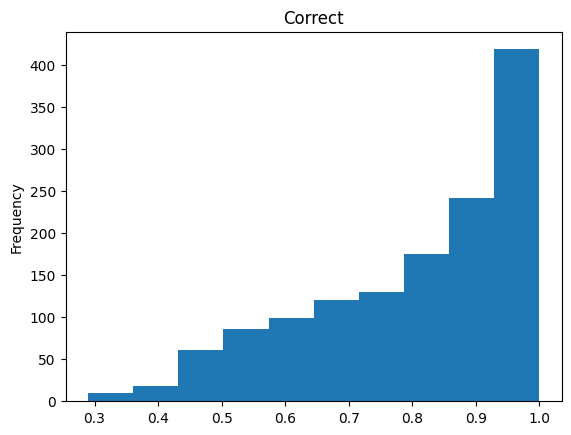

In [14]:
import matplotlib.pyplot as plt
correct["max_probability"].plot.hist(title="Correct")
plt.show()

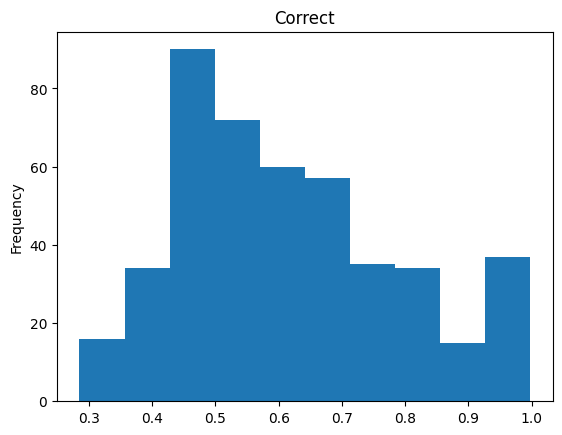

In [15]:
wrong["max_probability"].plot.hist(title="Correct")
plt.show()

In [16]:
high = er[er["max_probability"] > 0.8]
print(len(high))
print(classification_report(high["actual"], high["predicted"]))

895
              precision    recall  f1-score   support

         APT       0.90      0.75      0.82        12
        Core       0.94      0.89      0.92       264
       Debug       0.94      0.99      0.96       202
         Doc       1.00      0.67      0.80         3
        Text       0.78      0.75      0.77        72
          UI       0.90      0.92      0.91       342

    accuracy                           0.91       895
   macro avg       0.91      0.83      0.86       895
weighted avg       0.91      0.91      0.91       895



In [17]:
print(len(er))
print(classification_report(er["actual"], er["predicted"]))

1811
              precision    recall  f1-score   support

         APT       0.90      0.56      0.69        16
        Core       0.76      0.77      0.76       546
       Debug       0.90      0.78      0.84       302
         Doc       1.00      0.25      0.40        12
        Text       0.64      0.51      0.57       236
          UI       0.72      0.82      0.77       699

    accuracy                           0.75      1811
   macro avg       0.82      0.62      0.67      1811
weighted avg       0.75      0.75      0.75      1811



### 예측 모델의 특성 중요도 측정

In [18]:
svc.coef_

<15x6403 sparse matrix of type '<class 'numpy.float64'>'
	with 64451 stored elements in Compressed Sparse Row format>

In [19]:
# Core와 UI
coef = svc.coef_[8].A[0]

In [20]:
vocabulary_positions = coef.argsort()
print(vocabulary_positions)

[4686 3296 5906 ... 2408  466 1108]


In [21]:
vocabulary = tfidf.get_feature_names_out()

In [22]:
top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

In [23]:
core_ui = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                          columns=["feature", "coefficient"]).sort_values("coefficient")

In [24]:
core_ui

,feature,coefficient
10,refactoring,-3.185952
11,junit,-2.921894
12,ui,-2.774312
13,wizard,-2.579320
14,page,-2.524853
15,dialog,-2.427787
16,extract,-2.253091
17,quickfix,-2.243411
18,preference,-2.205799
19,quick,-2.041430


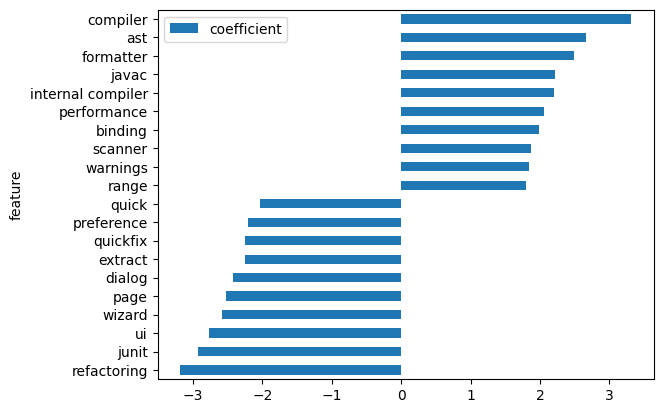

In [25]:
core_ui.set_index("feature").plot.barh()
plt.show()

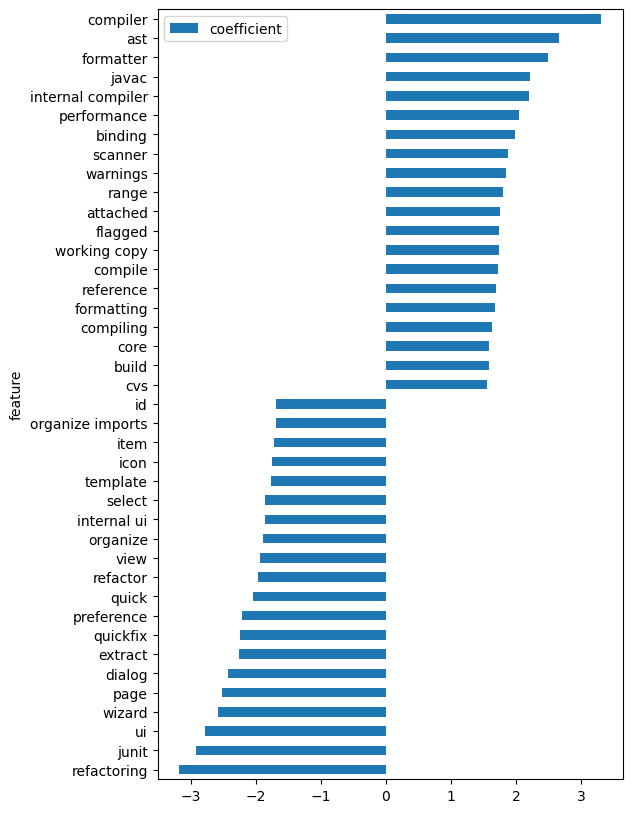

In [26]:
top_words = 20
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()
core = pd.DataFrame([[vocabulary[c], coef[c]] for c in top_positive_coef + top_negative_coef], 
                       columns=["feature", "coefficient"]).sort_values("coefficient")
core.set_index("feature").plot.barh(figsize=(6, 10))
plt.show()

### LIME을 사용한 분류 결과 설명

In [27]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(tfidf, svc)

In [28]:
pipeline.predict_proba(["compiler not working"])

array([[0.00240522, 0.95605684, 0.00440957, 0.00100242, 0.00971824,
        0.02640771]])

In [29]:
class_names

['APT', 'Core', 'Debug', 'Doc', 'Text', 'UI']

In [30]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [31]:
er[er["predicted"] != er["actual"]].head(5)

,index,text,actual,predicted,APT,Core,Debug,Doc,Text,UI,max_probability
2,2,NPE in Delta processor while executing JDT/UI ...,Core,UI,0.003357,0.309548,0.046491,0.002031,0.012309,0.626265,0.626265
15,15,Inserting a block of text in editor badly alig...,UI,Text,0.001576,0.063076,0.034610,0.003907,0.614473,0.282356,0.614473
16,16,Differences when debugging identical objects W...,Debug,Core,0.002677,0.430862,0.313465,0.004193,0.055838,0.192965,0.430862
20,20,Foreach template doesnt work for class members...,Core,UI,0.000880,0.044018,0.001019,0.000783,0.130766,0.822535,0.822535
21,21,exchange left and right operands for compariso...,UI,Core,0.002669,0.467366,0.077252,0.003194,0.068749,0.380770,0.467366


In [32]:
id = 21
print('Document id: %d' % id)
print('Predicted class =', er.iloc[id]["predicted"])
print('True class: %s' % er.iloc[id]["actual"])

Document id: 21
Predicted class = Core
True class: UI


In [33]:
exp = explainer.explain_instance(result.iloc[id]["text"], pipeline.predict_proba, num_features=10, labels=[1, 5])
print('Explanation for class %s' % class_names[1])
print('\n'.join(map(str, exp.as_list(label=1))))
print()
print('Explanation for class %s' % class_names[5])
print('\n'.join(map(str, exp.as_list(label=5))))

Explanation for class Core
('fix', -0.14382480492123437)
('Bug', 0.14134873296001446)
('following', 0.1077281542729411)
('comparison', 0.09994281578441859)
('Fix', -0.08930563108533972)
('right', 0.08638459750348165)
('semantics', 0.08355087686711156)
('changes', -0.08160933259246649)
('left', 0.03576751457641427)
('not', 0.0013948232947249468)

Explanation for class UI
('Bug', -0.15142728492589821)
('fix', 0.15085812524377776)
('right', 0.10857096839047532)
('comparison', -0.10787245100905508)
('left', -0.10313991248145736)
('following', -0.09914605896899485)
('semantics', -0.05946401848200334)
('Fix', 0.05446484907431909)
('good', 0.04205314282778648)
('changes', 0.038152334298865866)


In [34]:
exp = explainer.explain_instance(result.iloc[id]["text"], pipeline.predict_proba, num_features=6, top_labels=3)
exp.show_in_notebook(text=False)

In [35]:
from lime import submodular_pick

import numpy as np
np.random.seed(42)
lsm = submodular_pick.SubmodularPick(explainer, er["text"].values, pipeline.predict_proba, 
                                        sample_size=100,
                                        num_features=20,
                                        num_exps_desired=5)

In [36]:
lsm.explanations[0].show_in_notebook()